In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import yaml
from pathlib import Path


import thermalizer.ks.solver as ks_solver
import thermalizer.dataset.datasets as datasets
import thermalizer.models.cnn as cnn
import thermalizer.systems.regression_systems as systems

In [2]:
config = yaml.safe_load(Path("config.yml").read_text())
print(config)

{'ks': {'L': 22, 'N': 128, 'dataset_size': 10000, 'trajectories': 5, 'increment': 50, 'rollout': 5, 'dt': 0.01, 'spinup': 5000, 'decorr_steps': 5000, 'valid_sims': 10, 'valid_window': 5000}, 'network': {'arch': 'CNN', 'input_channels': 1, 'output_channels': 1}, 'optimization': {'batch_size': 64, 'lr': 0.001, 'wd': 0.05, 'epochs': 10}}


In [3]:
## Determine number of sims to run to generate the training set size
## Lets say trajectories per IC
config["ks"]["num_sims"]=config["ks"]["dataset_size"]//config["ks"]["trajectories"]
config["ks"]["nsteps"]=config["ks"]["spinup"]+config["ks"]["trajectories"]*config["ks"]["decorr_steps"]+config["ks"]["increment"]*config["ks"]["rollout"]

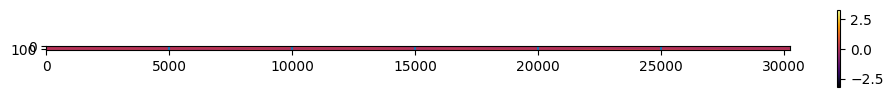

In [4]:
## First test a training sim

ks=ks_solver.KS(L=config["ks"]["L"],N=config["ks"]["N"],nsteps=config["ks"]["nsteps"],dt=config["ks"]["dt"])
ks.simulate()
ks_evol=np.fft.ifft(ks.vv,axis=-1).real
fig=plt.figure(figsize=(12,1))
plt.imshow(ks_evol.T,cmap="inferno")
plt.axvline(config["ks"]["spinup"])
for aa in range(1,config["ks"]["trajectories"]+1):
    plt.axvline(config["ks"]["decorr_steps"]*aa)
plt.colorbar()

100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


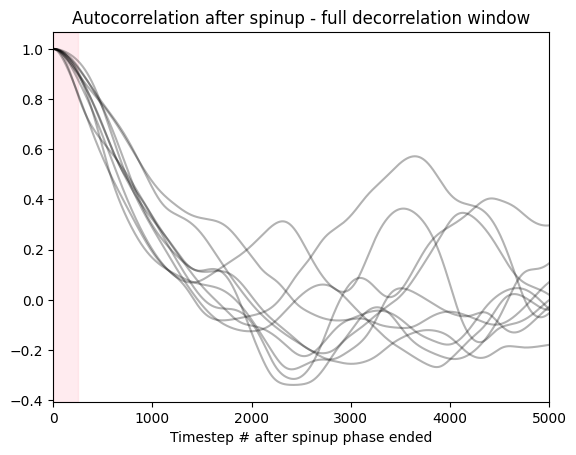

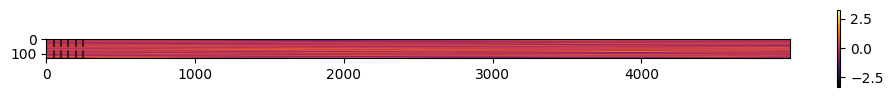

In [5]:
## Both produce validation plot, and also inspect a single training horizon/decorrelation window

fig=plt.figure()
kespec=np.zeros(config["ks"]["N"]//2+1)
valid_data=torch.empty(config["ks"]["valid_sims"],
                       config["ks"]["valid_window"],
                       config["ks"]["N"])

for aa in tqdm(range(config["ks"]["valid_sims"])):
    ks=ks_solver.KS(L=config["ks"]["L"],N=config["ks"]["N"],nsteps=config["ks"]["spinup"]+config["ks"]["valid_window"],dt=config["ks"]["dt"])
    ks.simulate()
    ks_evol=np.fft.ifft(ks.vv,axis=-1).real

    ## Get kespec of last snapshot to average
    kespec+=abs(np.fft.rfftn(ks_evol[-1])**2)
    
    corrs=[]
    ## Plot correlation between timesteps
    for bb in range(config["ks"]["spinup"],len(ks_evol)-1):
        corrs.append(pearsonr(ks_evol.T[:,config["ks"]["spinup"]].flatten(),ks_evol.T[:,bb].flatten())[0])
    plt.title("Autocorrelation after spinup - full decorrelation window")
    plt.plot(corrs,color="black",alpha=0.3)
    plt.xlabel("Timestep # after spinup phase ended")
    valid_data[aa]=torch.tensor(ks_evol[config["ks"]["spinup"]:-1])
    
    
plt.axvspan(0,config["ks"]["increment"]*config["ks"]["rollout"],color="pink",alpha=0.3)
plt.xlim(0,config["ks"]["decorr_steps"])


## Plot a single validation sim
fig=plt.figure(figsize=(12,1))
plt.imshow(valid_data[0].T,cmap="inferno")
for aa in range(1,config["ks"]["rollout"]+1):
    plt.axvline(config["ks"]["increment"]*aa,color="black",linestyle="dashed",alpha=0.6)
plt.colorbar()

In [ ]:
## Plot a single validation sim
fig=plt.figure(figsize=(12,1))
plt.imshow(valid_data[0].T,cmap="inferno")
for aa in range(1,config["ks"]["rollout"]+1):
    plt.axvline(config["ks"]["increment"]*aa,color="black",linestyle="dashed",alpha=0.6)
plt.colorbar()

In [ ]:
valid_data[0].shape

In [ ]:
## Build training dataset
train_data=torch.empty(config["ks"]["num_sims"],
                       config["ks"]["rollout"],
                       config["ks"]["N"])

for aa in tqdm(range(config["ks"]["num_sims"])):
    ks=ks_solver.KS(L=config["ks"]["L"],N=config["ks"]["N"],nsteps=config["ks"]["nsteps"],dt=config["ks"]["dt"])
    ks.simulate()
    ks_evol=np.fft.ifft(ks.vv,axis=-1).real
    for bb in range(config["ks"]["trajectories"]):
        for cc in range(config["ks"]["rollout"]):
            train_data[config["ks"]["trajectories"]*aa+bb,cc]=torch.tensor(ks_evol[config["ks"]["spinup"]+config["ks"]["decorr_steps"]*bb+cc*config["ks"]["increment"]])

In [ ]:
nsteps

In [ ]:
ks=ks_solver.KS(L=config["ks"]["L"],N=config["ks"]["N"],nsteps=1600,dt=config["ks"]["dt"])
ks.simulate()
ks_evol=np.fft.ifft(ks.vv,axis=-1).real

In [ ]:
fig=plt.figure(figsize=(12,1))
plt.imshow(ks_evol.T,cmap="inferno")
plt.axvline(config["ks"]["spinup"])
plt.axvline(config["ks"]["decorr_steps"])
plt.colorbar()